## Задачи исследования

Цель исследования - компании «Работа с заботой» необходимо оптимизировать управление персоналом: важно понять как  избежать финансовых потерь из-за оттока сотрудников.Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 
 
Задача 1 — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 
Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков.

Задача 2 — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

## Импорты и уставновка библиотек

In [1]:
!pip install matplotlib==3.5.0 -U -q
!pip install -U scikit-learn -q
!pip install shap -q
!pip install phik -q
!pip install typing-extensions --upgrade -q
!pip install ydata-profiling -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.0.17 requires pydantic!=1.8,!=1.8.1,<1.9.0,>=1.7.4, but you have pydantic 2.7.4 which is incompatible.
spacy 3.2.0 requires pydantic!=1.8,!=1.8.1,<1.9.0,>=1.7.4, but you have pydantic 2.7.4 which is incompatible.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import ydata_profiling as yd

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import  make_scorer, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier # пробуем дополнительно
from sklearn.svm import SVC

from phik.report import plot_correlation_matrix

In [3]:
# настраиваем отображение таблиц
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [4]:
# обьявляем константы
RANDOM_STATE = 42
TEST_SIZE = 0.25

## Задача 1

### Загрузка данных

In [5]:
try:
    df_train=pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
    df_train.name='df_train'
except:
    df_train = pd.read_csv('https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv')
    df_train.name='df_train'


In [6]:
try:
    X_test=pd.read_csv('/datasets/test_features.csv')
    X_test.name='X_test'
except:
    X_test = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv')
    X_test.name='X_test'


In [7]:
try:
    y_test = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')
    y_test.name='y_test'
except:
    y_test = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv')
    y_test.name='y_test'


### Предварительный осмотр данных

In [8]:
df_list=[df_train, X_test, y_test]

In [9]:
for df in df_list:
    print(f'Первые пять строчек датафрейма {df.name}:')
    display(df.head())
    print()
    print(f'Общая информация о датафрейме {df.name}:')
    df.info()
    print()

Первые пять строчек датафрейма df_train:


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20



Общая информация о датафрейме df_train:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB

Первые пять строчек датафрейма X_test:


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800



Общая информация о датафрейме X_test:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB

Первые пять строчек датафрейма y_test:


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08



Общая информация о датафрейме y_test:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB



In [10]:
# циклом проходимся по всем датафреймам для поиска явных дубликатов
for df in df_list:
    print(f'Количество явных дубликатов в {df.name} - {df.duplicated().sum()}')

Количество явных дубликатов в df_train - 0
Количество явных дубликатов в X_test - 0
Количество явных дубликатов в y_test - 0


In [11]:
# смотрим неявные дубликаты и коррекность значений 
for df in df_list:
    for column in df.select_dtypes(exclude=np.number).columns.to_list():
        print(f' Список уникальных значений столбца "{column}" датафрейма {df.name}')
        print(df[column].unique())
        print()

 Список уникальных значений столбца "dept" датафрейма df_train
['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]

 Список уникальных значений столбца "level" датафрейма df_train
['junior' 'middle' 'sinior' nan]

 Список уникальных значений столбца "workload" датафрейма df_train
['medium' 'high' 'low']

 Список уникальных значений столбца "last_year_promo" датафрейма df_train
['no' 'yes']

 Список уникальных значений столбца "last_year_violations" датафрейма df_train
['no' 'yes']

 Список уникальных значений столбца "dept" датафрейма X_test
['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']

 Список уникальных значений столбца "level" датафрейма X_test
['junior' 'middle' 'sinior' nan]

 Список уникальных значений столбца "workload" датафрейма X_test
['medium' 'low' 'high' ' ']

 Список уникальных значений столбца "last_year_promo" датафрейма X_test
['no' 'yes']

 Список уникальных значений столбца "last_year_violations" датафрейма X_test
['no' 'yes']



***Предварительные выводы:***

**df_train** - типизация данных корректна, явных дубликатов необнаружено, есть пропуски в колонках dept и level, есть некорректные данные в колонках level.

**X_test** - типизация данных корректна, явных дубликатов необнаружено, есть пропуски в колонках dept и level, есть некорректные данные в колонках level, dept и workload.

**y_test** - типизация данных корректна, явных дубликатов необнаружено, нет пропусков данных.

### Предобработка данных

In [12]:
# устраним орфографические ошибки в данных
df_train['level'] = df_train['level'].replace('sinior', 'senior')
X_test['level'] = X_test['level'].replace('sinior', 'senior')

In [13]:
df_train['level'].unique()

array(['junior', 'middle', 'senior', nan], dtype=object)

In [14]:
# заполним некорректные пропуски значением Nan, что бы корректно обработать в пайплайне
X_test[X_test['dept']==' ']=np.nan
X_test[X_test['workload']==' ']=np.nan

In [15]:
X_test['dept'].unique()

array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan],
      dtype=object)

***Предварительные выводы:***

**df_train** - обработали орфографические ошибки в колонках level.

**X_test** - обработали орфографические ошибки в колонках level, обработали некорректные пропуски dept и workload.


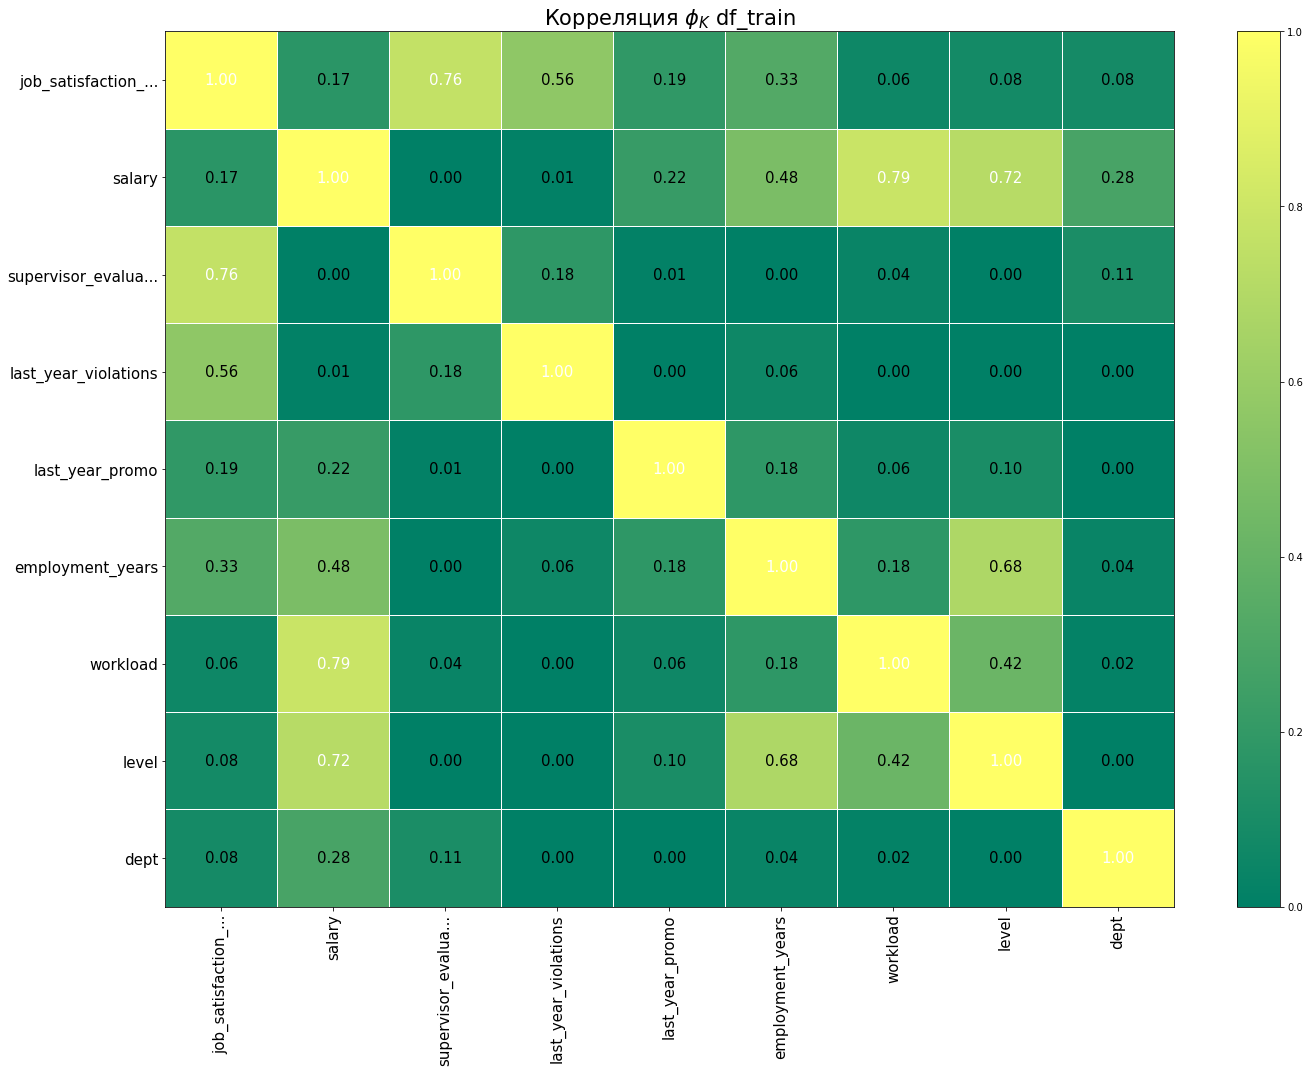

In [19]:
phik_overview = (
    df_train
    .drop('id', axis=1)
    .phik_matrix(verbose=False, interval_cols=['supervisor_evaluation','salary', 'job_satisfaction_rate']))

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='summer',
    title=r'Корреляция $\phi_K$ df_train',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

О мультиколлинеарности свидетельствует значение коэффициента корреляции от 0.9 до 0.95 по модулю, в данном случае мультиколлинеарность отсутствует.

Самая значимая взаимосвязь между входными признаками выражена значением - 0.79 - между workload и salary, а так же level и salary - 0.72.

Наиболее значимые взимосвязи видим между целевым признаком 'job_satisfaction_rate' и входными признаками:

'supervisor_evaluation' - 0.76;
'last_year_violations' - 0.56.


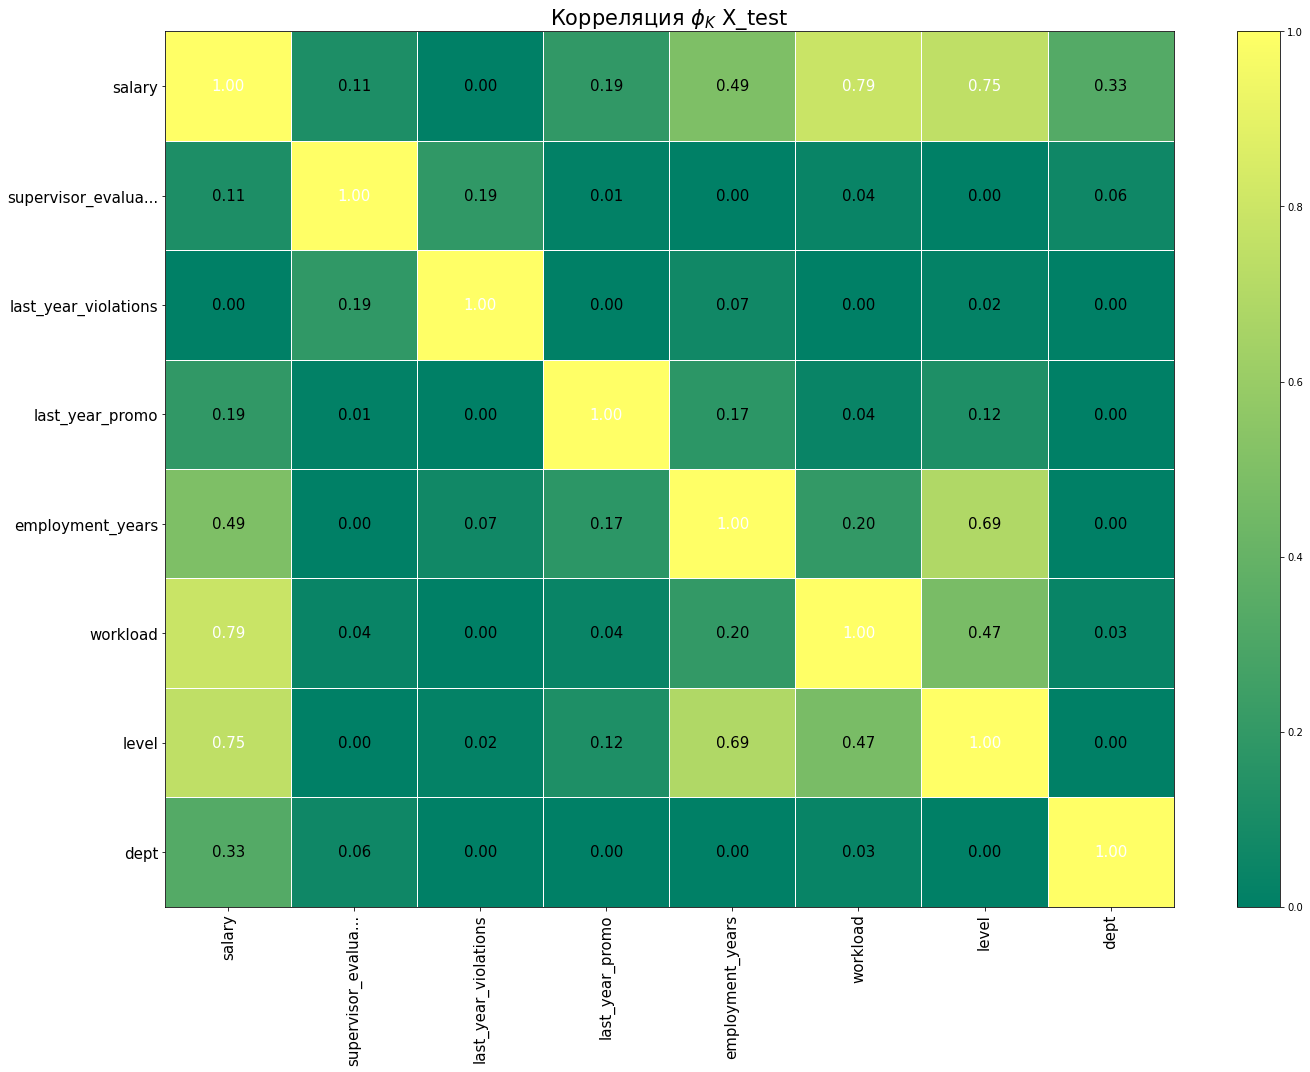

In [20]:
phik_overview = (
    X_test
    .drop('id', axis=1)
    .phik_matrix(verbose=False, interval_cols=['supervisor_evaluation','salary']))

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='summer',
    title=r'Корреляция $\phi_K$ X_test',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

Похожую картину наблюдаем на выборке тестовых признаков. Отсутствие мультиколлинеарности. Самая значимая взаимосвязь между входными признаками выражена значением - 0.79 - между workload и salary, а так же level и salary - 0.75.


***Промежуточные выводы:***

**df_train**
Явных дубликатов не обнаружено, типизация данных корректна.
Категориальные данные:
dept, level, workload,last_year_promo,last_year_violations - данные корректны. Исправлены пропуски данных на значение Nan для успешной обработки в пайплайне.

Количественные данные: 
employment_years, supervisor_evaluation, salary, job_satisfaction_rate - данные корректы крупных аномалий и выбросов не обнаружено. Пропусков данных нет.

Мультиколлинеарность отсутствует. Можем увидеть высокую корреляцию между признаками 
employment_years/level, salary/level, workload/salary.

**X_test**
Явных дубликатов не обнаружено, типизация данных корректна.
Категориальные данные:
dept, level, workload,last_year_promo,last_year_violations - данные корректны. Исправлены пропуски данных на значение Nan для успешной обработки в пайплайне.

Количественные данные: 
employment_years, supervisor_evaluation, salary - данные корректы крупных аномалий и выбросов не обнаружено. Пропусков данных нет.
Мультиколлинеарность отсутствует. Можем увидеть высокую корреляцию между признаками 
employment_years/level, salary/level, workload/salary.

**y_test**
Пропусков не обнаружено, типизация данных корректна. 

### Подготовка пайплайна

#### Предобработка данных для пайплайна

In [21]:
# подготовим тестовый датасет, совместим по индексам признаки
df_test=X_test.merge(y_test, on='id')
df_test.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046.0,marketing,junior,medium,2.0,no,no,5.0,28800.0,0.79
1,686555.0,hr,junior,medium,1.0,no,no,4.0,30000.0,0.72
2,467458.0,sales,middle,low,5.0,no,no,4.0,19200.0,0.64
3,418655.0,sales,middle,low,6.0,no,no,4.0,19200.0,0.60
4,789145.0,hr,middle,medium,5.0,no,no,5.0,40800.0,0.75


In [22]:
# выделяем в отдельные переменные целевой признак и входные признаки
X_train = df_train.drop(columns=['job_satisfaction_rate', 'id'], axis=True)
y_train = df_train['job_satisfaction_rate']
X_train.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,sales,junior,medium,2,no,no,1,24000
1,hr,junior,high,2,no,no,5,38400
2,sales,junior,low,1,no,no,2,12000
3,technology,junior,low,4,no,no,2,18000
4,hr,junior,medium,1,no,no,3,22800


In [23]:
# создаём списки с названиями признаков 
num_columns = ['salary',
               'employment_years',
               'supervisor_evaluation'
               ]

ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']

ord_columns = ['level', 'workload']

In [24]:
# создаём пайплайн для подготовки признаков из списка ohe_columns
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output =False))
    ]
) 

# создаём пайплайн для подготовки признаков из списка ord_columns
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[['junior', 'middle', 'senior'], 
                    ['low', 'medium', 'high']], 
                handle_unknown='use_encoded_value', unknown_value=np.nan)),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ]
) 

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [25]:
# напишем функцию для рассчета метрики SMAP
def smape(y_true, y_pred):
    """
    Вычисляет симметричную среднюю абсолютную процентную ошибку между фактическими и прогнозируемыми значениями.
    
    :param y_true: список фактических значений
    :param y_pred: список прогнозируемых значений
    """
    # Проверка, что списки имеют одинаковую длину
    assert len(y_true) == len(y_pred), "Списки должны быть одинаковой длины"
    
    # Расчет абсолютных процентных ошибок
    errors = [2 * abs(true - pred) / (abs(true) + abs(pred)) for true, pred in zip(y_true, y_pred) if (true + pred) != 0]
    
    # Исключение случаев, когда сумма фактического и прогнозируемого значения равна 0, для предотвращения деления на 0
    # Расчет среднего значения (SMAPE)
    smape_value = sum(errors) / len(errors) * 100
    return smape_value
    
smape_scorer = make_scorer(smape, greater_is_better = False)

#### Создание итогового пайплайна

Создадим пайплайн, который выберет лучшую комбинацию модели и гиперпараметров. Используем модели:

- DecisionTreeRegressor() с гиперпараметрами max_depth None или 2 до 15 включительно, max_features от 2 до 15 включительно, min_sample_split  от 2 до 15;

- KNeighborsRegressor() с гиперпараметром n_neighbors от 2 до 11 включительно, вариацией алгоритма ['auto', 'ball_tree', 'kd_tree', 'brute'];

- LinearRegression;

Рассчитаем метрику SMAPE на тренировочной и тестовой выборках для лучшей модели.Критерий успеха: SMAPE≤15 на тестовой выборке.

In [26]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

param_grid = [
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': [None] + [i for i in range(2, 15)],
        'models__max_features': range(2, 15),
        'models__min_samples_split': range(2, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]  
    },
    # словарь для модели KNeighborsRegressor()
        {
        'models': [KNeighborsRegressor()],
        'models__n_neighbors': range(2, 11),
        'models__algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]   
    },

    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    
   
]


In [27]:
# ищем лучшую модель 
random_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=smape_scorer,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
random_search.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', random_search.best_estimator_)
print()
print()
print(f'Параметры лучшей модели:\n{random_search.best_params_}')
print()
print()
print ('Метрика лучшей модели на тренировочной выборке:', -random_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                            

In [28]:
# посмотрим на метрики 5 лучших моделей
pd.DataFrame(random_search.cv_results_)[
    ['std_test_score', 'rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score')[:5]

,std_test_score,rank_test_score,param_models,mean_test_score,params
8,0.552968,1,DecisionTreeRegressor(random_state=42),-14.737957,"{'preprocessor__num': MinMaxScaler(), 'models__min_samples_split': 14, 'models__max_features': 13, 'models__max_depth': None, 'models': DecisionTreeRegressor(random_state=42)}"
1,0.592211,2,DecisionTreeRegressor(random_state=42),-15.405354,"{'preprocessor__num': RobustScaler(), 'models__min_samples_split': 4, 'models__max_features': 10, 'models__max_depth': 11, 'models': DecisionTreeRegressor(random_state=42)}"
7,0.357713,3,DecisionTreeRegressor(random_state=42),-15.420736,"{'preprocessor__num': MinMaxScaler(), 'models__min_samples_split': 10, 'models__max_features': 6, 'models__max_depth': 13, 'models': DecisionTreeRegressor(random_state=42)}"
9,0.595822,4,DecisionTreeRegressor(random_state=42),-15.444281,"{'preprocessor__num': StandardScaler(), 'models__min_samples_split': 12, 'models__max_features': 8, 'models__max_depth': 11, 'models': DecisionTreeRegressor(random_state=42)}"
6,0.435018,5,DecisionTreeRegressor(random_state=42),-16.253427,"{'preprocessor__num': MinMaxScaler(), 'models__min_samples_split': 2, 'models__max_features': 6, 'models__max_depth': 12, 'models': DecisionTreeRegressor(random_state=42)}"


#### Проверка лучшей модели

In [29]:
# достаем нашу лучшую обученную модель
best_model = random_search.best_estimator_
# получаем предсказания для тестовой выборки
y_predict = best_model.predict(df_test.drop(['id','job_satisfaction_rate'], axis=True))

In [30]:
print('Метрика SMAPE у лучшей модели на тестовых данных составляет - ',
      round(smape(df_test['job_satisfaction_rate'], y_predict),2))

Метрика SMAPE у лучшей модели на тестовых данных составляет -  13.64


***Промежуточные выводы***

Успех! На тренировочных данных лучшая из обученных моделей ***DecisionTreeRegressor*** (с гиперпараметрами  'models__min_samples_split': 14, 'models__max_features': 13, 'models__max_depth': None, предобработка данных при помощи  MinMaxScaler()) имеет показатель SMAP - ***14.73***, на тестовых - ***13.64***. Это соответствует критериям отбора по условию. Лучшая модель найдена.

### Выводы по задаче 1

На данном шаге были изучены и обработаны данные анкетировани сотрудников компании для построения модели, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. Т.к. многие признаки связаны между собой нелинейно лучшей себя показала модель DecisionTreeRegressor (с гиперпараметрами 'models__min_samples_split': 14, 'models__max_features': 13, 'models__max_depth': None, предобработка данных при помощи MinMaxScaler()), метрика на тестовых данных соответствует критериям успеха. Будем использовать данную модель для дальнейшего исследования.

## Задача 2

### Загрузка данных

In [31]:
X_test_quit = X_test.copy()

In [32]:
try:
    df_train_quit=pd.read_csv('/datasets/train_quit.csv')
    df_train_quit.name='df_train_quit'
except:
    df_train_quit=pd.read_csv('https://code.s3.yandex.net/datasets/train_quit.csv')
    df_train_quit.name='df_train_quit'


In [33]:
try:
    y_test_quit=pd.read_csv('/datasets/test_target_quit.csv')
    y_test_quit.name='y_test_quit'
except:
    y_test_quit=pd.read_csv('https://code.s3.yandex.net/datasets/test_target_quit.csv')
    y_test_quit.name='y_test_quit'


### Предварительный осмотр данных

In [34]:
df_list=[df_train_quit, y_test_quit]

In [35]:
for df in df_list:
    print(f'Первые пять строчек датафрейма {df.name}:')
    display(df.head())
    print()
    print(f'Общая информация о датафрейме {df.name}:')
    df.info()
    print()

Первые пять строчек датафрейма df_train_quit:


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no



Общая информация о датафрейме df_train_quit:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB

Первые пять строчек датафрейма y_test_quit:


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes



Общая информация о датафрейме y_test_quit:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB



In [36]:
# смотрим неявные дубликаты и коррекность значений 
for df in df_list:
    for column in df.select_dtypes(exclude=np.number).columns.to_list():
        print(f' Список уникальных значений столбца "{column}" датафрейма {df.name}')
        print(df[column].unique())
        print()

 Список уникальных значений столбца "dept" датафрейма df_train_quit
['sales' 'purchasing' 'marketing' 'technology' 'hr']

 Список уникальных значений столбца "level" датафрейма df_train_quit
['middle' 'junior' 'sinior']

 Список уникальных значений столбца "workload" датафрейма df_train_quit
['high' 'medium' 'low']

 Список уникальных значений столбца "last_year_promo" датафрейма df_train_quit
['no' 'yes']

 Список уникальных значений столбца "last_year_violations" датафрейма df_train_quit
['no' 'yes']

 Список уникальных значений столбца "quit" датафрейма df_train_quit
['no' 'yes']

 Список уникальных значений столбца "quit" датафрейма y_test_quit
['yes' 'no']



Данные в  df_train_quit и y_test_quit корректно типизированы, нет явных и неявных дубликатов и пропусков.

In [39]:
df_train_quit['level'] = df_train['level'].replace('sinior', 'senior')

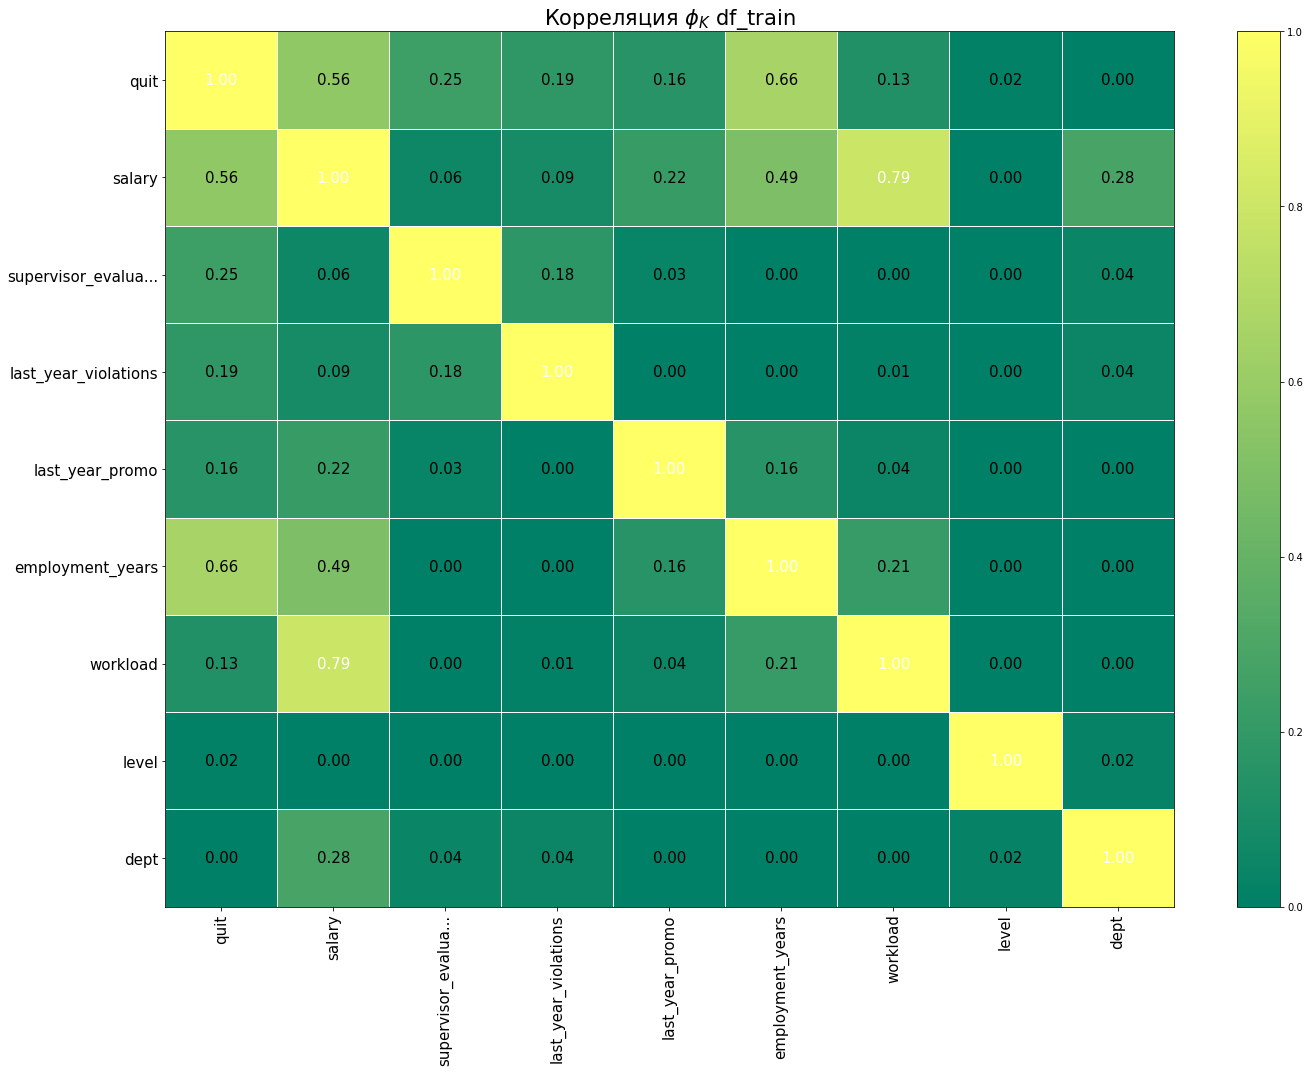

In [40]:
phik_overview = (
    df_train_quit
    .drop('id', axis=1)
    .phik_matrix(verbose=False, interval_cols=['supervisor_evaluation','salary']))

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='summer',
    title=r'Корреляция $\phi_K$ df_train',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

О мультиколлинеарности свидетельствует значение коэффициента корреляции от 0.9 до 0.95 по модулю, в данном случае мультиколлинеарность отсутствует.
Самая значимая взаимосвязь между входными признаками выражена значением - 0.79 - между workload и salary.

Наиболее значимые взимосвязи видим между целевым признаком 'quit' и входными признаками:

- 'employment_years' - 0.66;
- 'salary' - 0.56.

Промежуточные выводы:

***df_train_quit***

Категориальные признаки  - данные корректны, есть пропущенные яцейки в колонке "level", они будут обработыны в пайплайне. Поправили орфографические ошибки.

Количественные признаки: - крупных выбросов и аномалий не обнаружено. Пропусков данных нет. 

Мультиколлинеарность отсутствует. Но можно увидель высокую корреляцию(>65) между признаками employment_years/quit, salary/workload.


***y_test_quit*** - данные корректы, пропусков нет. Распределение непропорционально, но в нашем исследовании это не повредит, т.к. выбоки уже подготовлены.

### Исследование признаков уволившихся сотрудников

In [41]:
def countplot(data, x, hue, count):
    """Функция для построения графика countplot и pie"""
    if count==2:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5), dpi=100)
        sns.countplot(data=data, x=x, hue=hue, palette=['g', 'yellow'], ax=axes[0])
        axes[0].grid(True, axis='y', linestyle='--')
        data.query('quit == "yes"')[x].value_counts().plot(y = 'count',
                                                           kind = 'pie',
                                                           autopct='%1.0f%%',
                                                           label='',
                                                           ax=axes[1],
                                                           colormap='summer',)
        axes[1].set_title('Процентное соотношение всех уволившихся');
    else:
        plt.figure(figsize=(10,5), dpi=100)
        sns.countplot(data=data, x=x, hue=hue, palette=['g', 'yellow'])
        plt.grid(True, axis='y', linestyle='--');


In [42]:
def df_percent(data, col):
    """функция для отображения датафрейма визуализируего доли уволившихся сотрудников"""
    df_new=pd.merge(data[col].value_counts(),data.query('quit=="yes"')[col].value_counts(),left_index=True, right_index=True)
    df_new.columns=['всего_сотрудников','уволилось_сотрудников']
    df_new['%_соотношение'] = round(df_new['уволилось_сотрудников']/df_new['всего_сотрудников']*100,2)
    display(df_new.sort_values(by='%_соотношение', ascending=False))

In [43]:
df_train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,junior,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,junior,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


Помотрим насколько зависит увольнение сотрудника от времени его пребывания в компании и заработной планы.

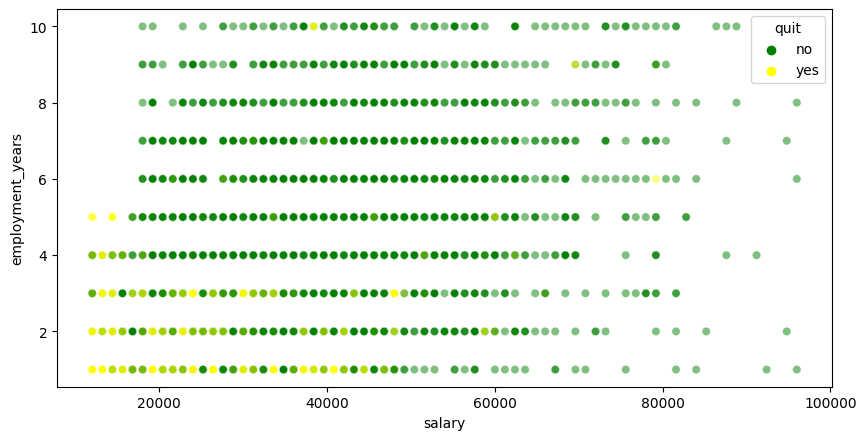

In [44]:
plt.figure(figsize=(10,5), dpi=100)
sns.scatterplot(x='salary', y='employment_years', hue='quit', data=df_train_quit, alpha=0.5, palette=['g', 'yellow']);

Основная часть уволившихся сотрудников проработала в компании менее 4х лет, а так же имела заработную плану < 500000.

Детальнее рассмотрим распределение уволившихся/оставшихся по времени работы в компании.

In [45]:
df_percent(df_train_quit, "employment_years")

,всего_сотрудников,уволилось_сотрудников,%_соотношение
1,985,599,60.81
2,777,290,37.32
3,479,163,34.03
4,393,27,6.87
5,362,23,6.35
6,296,10,3.38
10,90,3,3.33
7,308,7,2.27
9,136,3,2.21
8,174,3,1.72


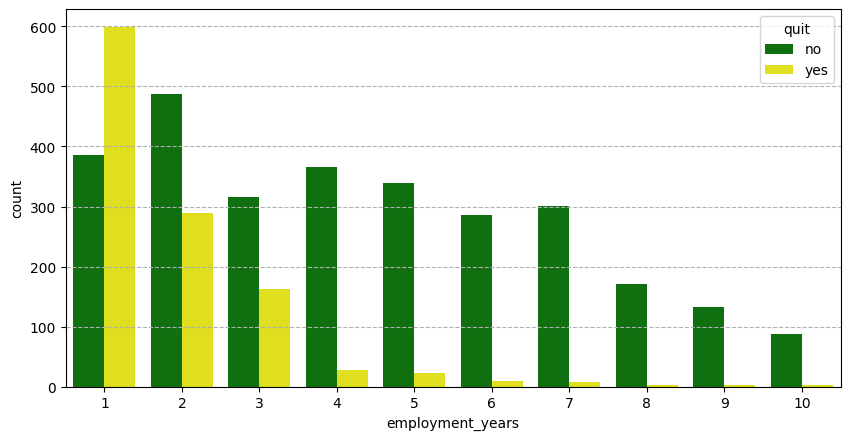

In [46]:
countplot(df_train_quit, "employment_years", "quit", 1)

Итак, больше всего увольнений просходит в 1-3 год работы в компании. Лидирует безусловно 1 год работы, больше уволившихся чем осташихся.

В процентном соотношеннии картина следующая:
- 60% сотрудников первого года уволились,
- 37-34% сотрудников увольняются на 2-3 год
- далее % увольнений падает ниже уровня 7% и колеблеблется в диапазоне 2-7%.

,salary
quit,
no,37702.228412
yes,23885.106383


Разница в средней зарплате 36.65 %


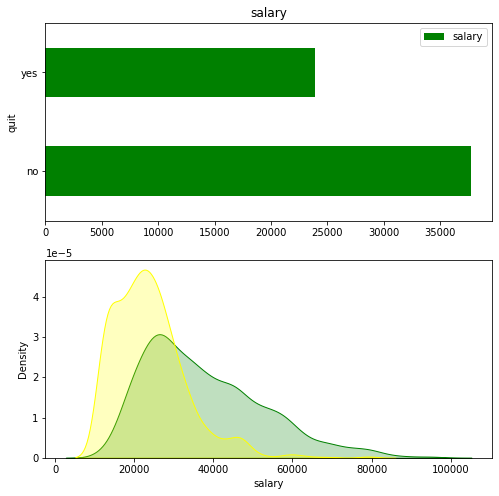

In [47]:
df_piv=df_train_quit.pivot_table(values='salary', index='quit', aggfunc='mean')
display(df_piv)
print('Разница в средней зарплате',round(((1-df_piv.min().values/df_piv.max().values)*100)[0],2), '%')

fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(8,8))
df_train_quit.pivot_table(values='salary', index='quit', aggfunc='mean').plot(kind='barh', subplots=True, color='green', ax=axes[0])
sns.kdeplot(df_train_quit[df_train_quit['quit']=='no']['salary'], color='g', fill=True, ax=axes[1])
sns.kdeplot(df_train_quit[df_train_quit['quit']=='yes']['salary'], color='yellow', fill=True, ax=axes[1]);

Средняя зарплата уволившегося сотрудника - 23 885, оставшегося - 37 702.

Т.е. средняя зарплата уволившегося сотрудникак на 36.65 % меньше.

График плотности распределения заработной платы так же показывает, что зарплаты уволившихся сотрудников меньше.

Посмотрим как обстоят дела с распределение увольнений в зависимости от отдела/грейда/загруженности.

In [48]:
df_percent(df_train_quit, "dept")

,всего_сотрудников,уволилось_сотрудников,%_соотношение
technology,928,276,29.74
sales,1438,407,28.30
purchasing,588,166,28.23
marketing,582,163,28.01
hr,464,116,25.00


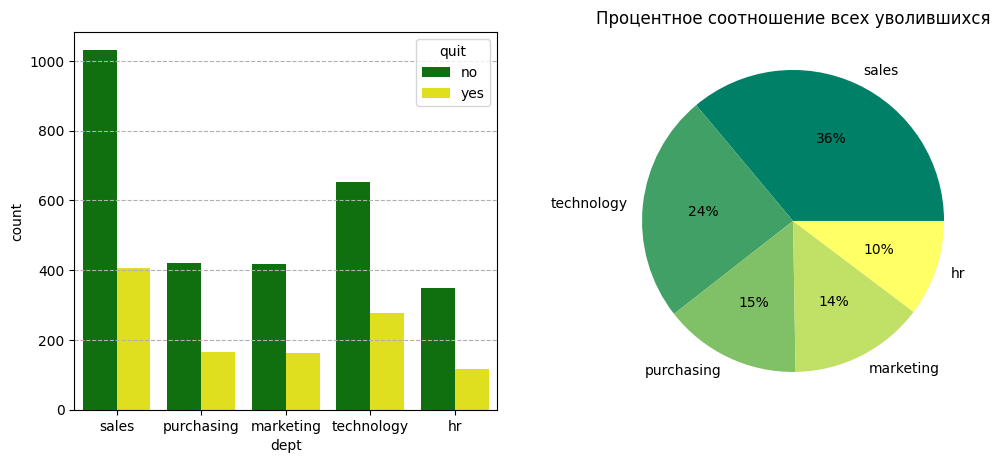

In [49]:
countplot(df_train_quit, "dept", "quit", 2)

Распределение увольнений по отделам в целом достаточно равномерное, зависит скорее от общего количетства сотрудников в отделе, чем от специализации. Количественно больше всего увольнений в самых крупных отделах - продажи и техотдел.

Самый большой процент увольнений в отделе technology - 29,74% 

Самый малый в отделе hr - 25%

Но как мы видим разрыв абсолютно незначительный.

In [50]:
df_percent(df_train_quit, "level")

,всего_сотрудников,уволилось_сотрудников,%_соотношение
middle,1744,514,29.47
junior,1894,527,27.82
senior,358,86,24.02


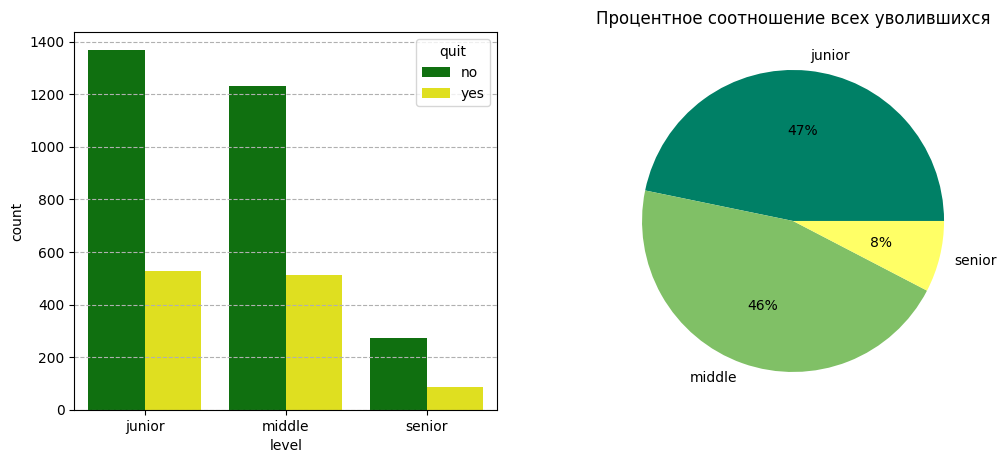

In [51]:
countplot(df_train_quit, "level", "quit", 2)

Примерное при всех уровенях занимаемой должности увольняется около трети сотрудников. Количественно соответственно больше увольнений среди мидл- и джуниор- сотрудников.

Наибольший процент увольнений среди middle-сотрудников - 29.47%, наименьший среди senior - 24.02%

In [52]:
df_percent(df_train_quit, "workload")

,всего_сотрудников,уволилось_сотрудников,%_соотношение
low,1208,519,42.96
medium,2118,488,23.04
high,674,121,17.95


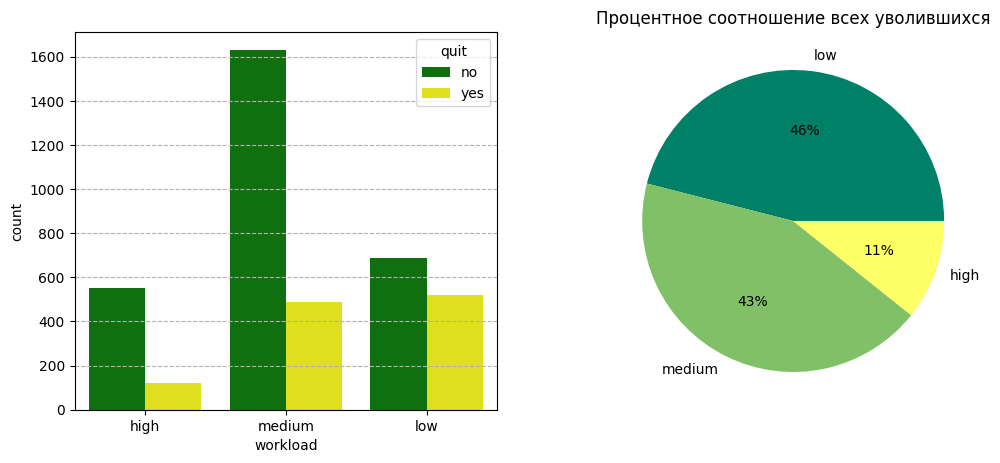

In [53]:
countplot(df_train_quit, "workload", "quit", 2)

Загруженность у уволившихся сотрудников скорее средняя или низкая, чем высокая. При этом сотрудники с низкой загруженностью увольняются чаще.

Самый большой процент увольнений у сотрудников с низкой загрузкой - 43%

Сотрудники с высокой загрузкой увольняются реже всего - только 18%.

***Промежуточные выводы:***

Уволившиеся сотрудники:
 - в основном специалисты проработавшие в компании 1-3 года, пик приходится на 1 год работы, увольняется около 60% сотрудников;
 - занимаюшие джуниор и мидл должности(увольняются 30% мидлов и 28% джунов);
 - с зарплатой ниже средней по компании на 36.65 %;
 - и с загруженностью среднего или низкого уровня(из сотрудников с низкой заггруженностью уволилось 43%, со средней 23%).

### Исследование связи уровень удовлетворения/увольнение

Добавим к входным данным спрогнозированный нами уровень удовлетворенности сотрудников компании и посмотрим как этот признак повлияет на вероятность увольнения.

In [54]:
df_train_quit['job_satisfaction'] =best_model.predict(df_train_quit.drop(columns=['id', 'quit'], axis=True))
df_train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction
0,723290,sales,junior,high,2,no,no,4,54000,no,0.808333
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.826111
2,155091,purchasing,junior,medium,5,no,no,1,37200,no,0.340000
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.340000
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.690000


,job_satisfaction
quit,
no,0.582398
yes,0.359021


Разница в удовлетвлренности работой 38.35 %


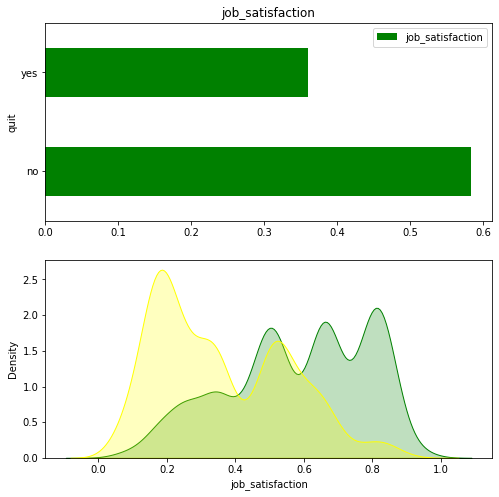

In [55]:
#print(df_train_quit.pivot_table(values='job_satisfaction', index='quit', aggfunc='mean'))
df_piv=df_train_quit.pivot_table(values='job_satisfaction', index='quit', aggfunc='mean')
display(df_piv)
print('Разница в удовлетвлренности работой',round(((1-df_piv.min().values/df_piv.max().values)*100)[0],2), '%')
fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(8,8))
df_train_quit.pivot_table(values='job_satisfaction', index='quit', aggfunc='mean').plot(kind='barh', subplots=True, color='green', ax=axes[0])
sns.kdeplot(df_train_quit[df_train_quit['quit']=='no']['job_satisfaction'], color='g', fill=True, ax=axes[1])
sns.kdeplot(df_train_quit[df_train_quit['quit']=='yes']['job_satisfaction'], color='yellow', fill=True, ax=axes[1]);

Уровень удовлетворённости работой уволившегося сотрудника на 38,35% ниже, чем оставшегося в копании. Плотность распределения чвно смещена влево в сторону ухудшения, а средний показатель у уволившихся - 0.35.

### Подготовка пайплайна

#### Предобработка входных данных

In [56]:
#создаем экземпляр класса LabelEncoder для кодирования целевого признака
lb_encoder = LabelEncoder()

In [57]:
#готовим тестовую выборку
df_test_q = X_test_quit.merge(y_test_quit, on='id')
df_test_q['job_satisfaction'] =best_model.predict(df_test_q.drop(columns=['id'], axis=True))
df_test_q.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction
0,485046.0,marketing,junior,medium,2.0,no,no,5.0,28800.0,no,0.883333
1,686555.0,hr,junior,medium,1.0,no,no,4.0,30000.0,no,0.676667
2,467458.0,sales,middle,low,5.0,no,no,4.0,19200.0,no,0.654167
3,418655.0,sales,middle,low,6.0,no,no,4.0,19200.0,no,0.666000
4,789145.0,hr,middle,medium,5.0,no,no,5.0,40800.0,no,0.825556


In [58]:
X_test_q=df_test_q.drop(columns=['quit', 'id'], axis=True)
y_test_q=df_test_q['quit']


In [59]:
# выделяем в отдельные переменные целевой признак и входные признаки
X_train_q = df_train_quit.drop(columns=['quit', 'id'], axis=True)
y_train_q = df_train_quit['quit']
X_train_q.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction
0,sales,junior,high,2,no,no,4,54000,0.808333
1,sales,junior,medium,2,no,no,4,27600,0.826111
2,purchasing,junior,medium,5,no,no,1,37200,0.340000
3,sales,junior,medium,2,no,yes,3,24000,0.340000
4,marketing,junior,medium,2,no,no,5,25200,0.690000


In [60]:
# обучаем энкодер и кодируем целевой признак тренировочной выборки
lb_encoder.fit(y_train_q)
y_train_q=lb_encoder.transform(y_train_q)
y_train_q

array([0, 0, 0, ..., 1, 0, 1])

In [61]:
#кодируем целевой признак тестовой выборки
y_test_q=lb_encoder.transform(y_test_q)
y_test_q

array([0, 0, 0, ..., 1, 0, 0])

Возьмем готовый пайплайн препроцессора из первой части исследования, добавив небольшие измениния.

In [62]:
# переопределим только num_columns
num_columns = ['salary',
               'employment_years',
               'supervisor_evaluation',
               'job_satisfaction'
               ]

#### Создание итового пайплайна

Создадим пайплайн, который выберет лучшую комбинацию модели и гиперпараметров. Используем модели:

- DecisionTreeClassifier() с гиперпараметрами max_depth от 2 до 15 включительно, max_features от 2 до 15 включительно;

- KNeighborsClassifier() с гиперпараметром n_neighbors от 2 до 15 включительно;

- LogisticRegression(solver='liblinear', penalty='l1') с гиперпараметром регуляризации С от 1 до 6 включительно;

- SVC(kernel='poly') с гиперпараметром degree от 1 до 11 включительно.

Рассчитаем метрику ROC-AUC на тренировочной и тестовой выборках для лучшей модели, критерий успеха: ROC-AUC≥0.91 на тестовой выборке.

In [63]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final_q = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid_q = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': [None] + [i for i in range(2, 15)],
        'models__max_features': range(2, 15), # максимум признаков 9  - пчм прокатило 15??? неверный момент ухудшивший поиск
        # как расчитывается кол-во признаков в зависимости от ohe кодировки????
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 6),
        #'models__C': np.logspace(0, 10, 20), - не прокатило, но это более верный подходб поверить по сетке
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]  
    },
    
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, probability= True)],
        'models__kernel': ['rbf', 'linear', 'sigmoid'], #- в сданой работе так, но не лучший метод
        'models__degree': range(1,11), # работает только для poly как степень полинома, зря указано в таком варианте
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]  

    },
    
]

In [64]:
random_search_q = RandomizedSearchCV(
    pipe_final_q, 
    param_grid_q, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)


random_search_q.fit(X_train_q, y_train_q)
probabilities = random_search_q.predict_proba(X_test_q)
probabilities_one = probabilities[:, 1]


print('Лучшая модель и её параметры:\n\n', random_search_q.best_estimator_)
print()
print()
print(f'Параметры лучшей модели:\n{random_search_q.best_params_}')
print()
print()
print ('Метрика лучшей модели на тренировочной выборке:', random_search_q.best_score_)
print()
print()
print('Площадь ROC-кривой на тестовой выборке:', roc_auc_score(y_test_q, probabilities_one))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                            

In [65]:
pd.DataFrame(random_search_q.cv_results_)[
    ['std_test_score', 'rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score')[:5]

,std_test_score,rank_test_score,param_models,mean_test_score,params
2,0.009740,1,DecisionTreeClassifier(random_state=42),0.914437,"{'preprocessor__num': RobustScaler(), 'models__max_features': 9, 'models__max_depth': 7, 'models': DecisionTreeClassifier(random_state=42)}"
9,0.009738,2,DecisionTreeClassifier(random_state=42),0.914262,"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 9, 'models__max_depth': 7, 'models': DecisionTreeClassifier(random_state=42)}"
5,0.014890,3,DecisionTreeClassifier(random_state=42),0.914103,"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 7, 'models__max_depth': 6, 'models': DecisionTreeClassifier(random_state=42)}"
7,0.004637,4,DecisionTreeClassifier(random_state=42),0.904627,"{'preprocessor__num': RobustScaler(), 'models__max_features': 8, 'models__max_depth': 5, 'models': DecisionTreeClassifier(random_state=42)}"
0,0.014281,5,DecisionTreeClassifier(random_state=42),0.899012,"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 6, 'models__max_depth': 8, 'models': DecisionTreeClassifier(random_state=42)}"


Лучшая модель - **DecisionTreeClassifier(random_state=42)** с гиперпараметрами **('models__max_features': 9, 'models__max_depth': 7)**

Метрика лучшей модели на тренировочной выборке: **0.9144**

Площадь ROC-кривой на тестовой выборке: **0.9147**

### Выводы по задаче 2

На данном шаге были изучены и обработаны данные анкетировани сотрудников компании для построения модели, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. Т.к. многие признаки связаны между собой нелинейно лучшей себя показала модель DecisionTreeClassifier(random_state=42) (с гиперпараметрами 'models__max_features': 9, 'models__max_depth': 7), метрика на тестовых данных соответствует критериям успеха. Цель исследования можно считать достигнутой. 

## Итоговые выводы


 - загружены имеющиеся данные из 5 файлов;
 - проведен анализ данных :
    - явные дубликаты не обнаружены;
    - исправлены некорректные пропуски данных;
    - рассмотрели распределение количественных и качественых признаков в каждом датафрейме;
    - выбросов не обнаружено;
    - мульколлинеарность отсутствует;
 - пропусков в данных не обнаружено, типизация данных во всех датафреймах корректна;
  
 - построили использовали пайплайн для задачи 1:
    - обьединили датафреймы;
    - построили пайплайн с моделями KNeighborsRegressor(), DecisionTreeRegressor(), LinearRegression() используя различные гиперпаметры для каждой;
    - по итогу выделили самую успешную модель:
        - DecisionTreeRegressor (с гиперпараметрами 'models__min_samples_split': 14, 'models__max_features': 13, 'models__max_depth': None, предобработка данных при помощи MinMaxScaler());
        - метрика SMAPE у лучшей модели на тестовых данных составляет -  13.64, что соответствует критерию успеха < 15.
        
 - проанализировали важность признаков для задачи 2:
   - составили примерный портрет уволившегося сотрудника:
        - в основном специалисты проработавшие в компании 1-3 года, пик приходится на 1 год работы, увольняется около 60% сотрудников;
        - занимаюшие джуниор и мидл должности(увольняются 30% мидлов и 28% джунов);
        - с зарплатой ниже средней по компании на 36.65 %;
        - и с загруженностью среднего или низкого уровня(из сотрудников с низкой заггруженностью уволилось 43%, со средней 23%).
        - уровень удовлетворённости работой уволившегося сотрудника на 38,35% ниже, чем оставшегося в копании;
          
 - построили использовали пайплайн для задачи 2:
    - закодировали целевой признак;
    - построили пайплайн с моделями KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и  SVC(), спользуя различные гиперпаметры для каждой;
    - по итогу выделили самую успешную модель:
        - DecisionTreeClassifier(random_state=42) с гиперпараметрами ('models__max_features': 9, 'models__max_depth': 7);
        - площадь ROC-кривой на тестовой выборке: у лучшей модели на тестовых данных составляет 0.9147, что соответствует критерию успеха > 0.91.
        
Дополнительные предложения для бизнеса:
- для составления более точного портрета сотрудника компании стоит расширить опросник - дополнительные знания о поле, возрасте, уровне образования, релевантном опыте могут значительно улучшить результаты прогнозов.
- рассмотреть задачу для кадрового отдела по анкетированию и тестированию сотрудников по вопросам реализации нематериальх потребностей внутри компании, при необходимости привлечь психолога, котрый будет вести эти исследования;
- на данные момент основной отток сотрудников происходит среди новых работников компании:
    - стоит обратить внимание на возможность проведения доп.обучений и тестирований сотрудников, при которых будет оцениваться их ценность для компании;
    - при развитии перспективных сотрудников сделать упор на визуализации их возможного роста, что бы человек понимал какие перспективы его ждут, конкретная визуализаци трудозатрат;
    - по возможности вводить программы лояльности для 'молодых сотрудников' - создания условий для проведения спортивногои культурного досуга, непосредственно в компании или вне ее пределов с частичной компенсацией.